<a href="https://colab.research.google.com/github/irfanshahmayeen/GR-08-CSE-445-Machine-Learnling-Stop-Sign-Detection-In-The-Street-/blob/yousuf1/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import matplotlib.pyplot as plt

# **Load & Preprocess Images**

In [ ]:
DATA_DIR = "/content/drive/MyDrive/project_445/Dataset"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                # [0,1]
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]
])

full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

In [ ]:
total = len(full_dataset)
train_len = int(0.7 * total)
val_len   = int(0.1 * total)
test_len  = total - train_len - val_len
train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len],
                                         generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# **Model create**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, h1, h2, num_classes, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(h2, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(IMG_SIZE*IMG_SIZE, 512, 256, NUM_CLASSES).to(DEVICE)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


In [ ]:
best_val_acc = 0.0
history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, 21):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        y_batch = y_batch.float().unsqueeze(1)  # Convert to float and shape [batch_size, 1]
        optimizer.zero_grad()
        logits = model(X_batch)  # Raw logits (no sigmoid yet)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    preds, truths = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            y_batch = y_batch.float().unsqueeze(1)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds.append((torch.sigmoid(logits) > 0.5).float().cpu().numpy())
            truths.append(y_batch.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    preds = np.concatenate(preds).flatten()
    truths = np.concatenate(truths).flatten()
    val_acc = accuracy_score(truths, preds)

    scheduler.step(val_loss)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mlp.pth")

Epoch 01 | Train Loss: 1.3334 | Val Loss: 2.6947 | Val Acc: 0.5000
Epoch 02 | Train Loss: 1.2004 | Val Loss: 1.1659 | Val Acc: 0.6000
Epoch 03 | Train Loss: 0.5864 | Val Loss: 1.8251 | Val Acc: 0.7000
Epoch 04 | Train Loss: 0.7672 | Val Loss: 1.8636 | Val Acc: 0.5000
Epoch 05 | Train Loss: 0.6327 | Val Loss: 0.8548 | Val Acc: 0.7000
Epoch 06 | Train Loss: 0.2927 | Val Loss: 1.2329 | Val Acc: 0.7000
Epoch 07 | Train Loss: 0.3445 | Val Loss: 0.9252 | Val Acc: 0.7000
Epoch 08 | Train Loss: 0.5202 | Val Loss: 1.3030 | Val Acc: 0.6000
Epoch 09 | Train Loss: 0.3150 | Val Loss: 2.1059 | Val Acc: 0.7000
Epoch 10 | Train Loss: 0.6027 | Val Loss: 2.0883 | Val Acc: 0.7000
Epoch 11 | Train Loss: 0.3765 | Val Loss: 1.9876 | Val Acc: 0.7000
Epoch 12 | Train Loss: 0.4291 | Val Loss: 1.7780 | Val Acc: 0.7000
Epoch 13 | Train Loss: 0.2856 | Val Loss: 1.5422 | Val Acc: 0.7000
Epoch 14 | Train Loss: 0.1076 | Val Loss: 1.5282 | Val Acc: 0.7000
Epoch 15 | Train Loss: 0.2907 | Val Loss: 1.5092 | Val Acc: 0.

# **Model Evaluate on Test Data**

Test Accuracy : 0.75
Precision     : 0.75
Recall        : 0.6666666666666666
F1 Score      : 0.7058823529411765


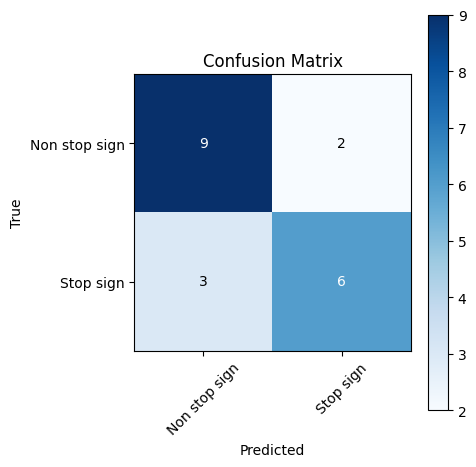

In [ ]:
model.load_state_dict(torch.load("best_mlp.pth"))
model.eval()

all_preds, all_truths = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        logits = model(X_batch)
        preds = (torch.sigmoid(logits) > 0.5).float().cpu().numpy()
        all_preds.append(preds)
        all_truths.append(y_batch.numpy())

y_pred = np.concatenate(all_preds).flatten()
y_true = np.concatenate(all_truths).flatten()

print("Test Accuracy :", accuracy_score(y_true, y_pred))
print("Precision     :", precision_score(y_true, y_pred))
print("Recall        :", recall_score(y_true, y_pred))
print("F1 Score      :", f1_score(y_true, y_pred))

# Confusion Matrix (unchanged)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(NUM_CLASSES)
plt.xticks(ticks, full_dataset.classes, rotation=45)
plt.yticks(ticks, full_dataset.classes)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()